# Generating the Style Dict for Folium

```
styledict = {
    '0': {
        '2017-1-1': {'color': 'ffffff', 'opacity': 1},
        '2017-1-2': {'color': 'fffff0', 'opacity': 1},
        ...
        },
    ...,
    'n': {
        '2017-1-1': {'color': 'ffffff', 'opacity': 1},
        '2017-1-2': {'color': 'fffff0', 'opacity': 1},
        ...
        }
}
```

## Imports and Loading Data

In [2]:
import pandas as pd

In [53]:
data = pd.read_csv("Cleaned_Data.csv")
data.drop(columns=['Unnamed: 0'], inplace=True)
data['Zip5'] = data['Zip5'].astype('int64')
data

,Num,year,A_Annual_Assesement,A_Taxes_and_Fees,Zip5
0,50299400,2023,4395607.0,2410.80,22302
1,50299400,2022,4395607.0,2296.00,22302
2,50299400,2021,4395607.0,1960.00,22302
3,50299400,2020,4395607.0,1120.00,22302
4,50299400,2019,4395607.0,1120.00,22302
...,...,...,...,...,...
451178,17341500,2015,1064188.0,11436.48,22314
451179,17341500,2014,999612.0,10758.45,22314
451180,17341500,2013,979751.0,10501.82,22314
451181,17341500,2012,966835.0,9321.01,22314


In [54]:
record_counts = data['Zip5'].value_counts()
print(record_counts)

Zip5
22314    156214
22304    102379
22302     55832
22301     51402
22305     39281
22312     25290
22311     20772
22320        13
Name: count, dtype: int64


## Calculating Time Series Data for each Zip Code

In [55]:
def get_average_taxes_and_fees_by_year(data):
    # Get all unique zip codes
    zip_codes = data['Zip5'].unique()
    # Create a new dataframe to store the average taxes and fees for each zip code and year
    average_taxes_and_fees = pd.DataFrame()
    # For each zip code, find the average taxes and fees for each year
    for zip_code in zip_codes:
        # Get all rows with the same zip code
        zip_code_rows = data.loc[data['Zip5'] == zip_code]
        # Group the rows by year and calculate the average taxes and fees
        yearly_average = zip_code_rows.groupby('year').agg({'A_Annual_Assesement': 'mean', 'A_Taxes_and_Fees': 'mean'}).reset_index()
        # Add the zip code to each row
        yearly_average['Zip5'] = zip_code
        # Append the yearly average to the dataframe
        average_taxes_and_fees = average_taxes_and_fees._append(yearly_average, ignore_index=True)
        average_taxes_and_fees['Zip5'] = average_taxes_and_fees['Zip5'].astype('int64')
    return average_taxes_and_fees


final = get_average_taxes_and_fees_by_year(data)

final = final[final['Zip5'] != 22320]
final


,year,A_Annual_Assesement,A_Taxes_and_Fees,Zip5
0,2008,7.053607e+05,6181.178061,22302
1,2009,7.628529e+05,7162.982895,22302
2,2010,5.848475e+05,5900.384234,22302
3,2011,6.144324e+05,6275.017184,22302
4,2012,6.237226e+05,6369.581514,22302
...,...,...,...,...
107,2019,1.659327e+06,13265.806503,22311
108,2020,1.694645e+06,13659.981890,22311
109,2021,1.770361e+06,14551.416549,22311
110,2022,1.856964e+06,15538.089418,22311


### Visualzing Time Series Data

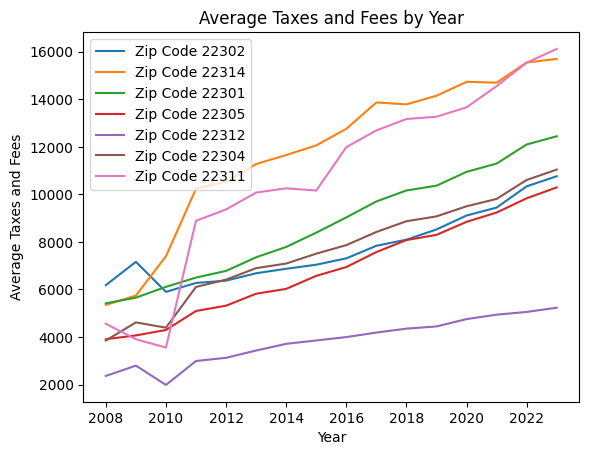

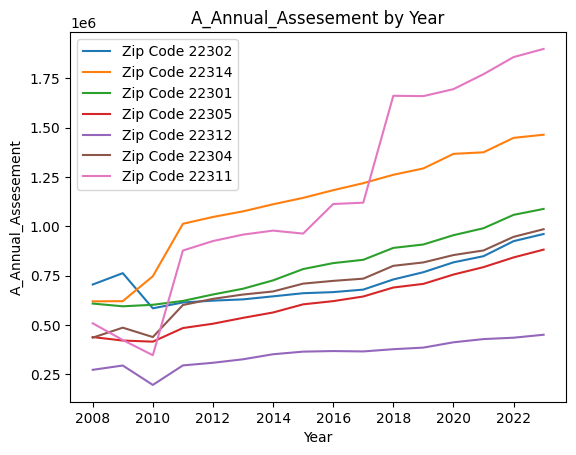

In [56]:
import matplotlib.pyplot as plt

def plot_average_taxes_and_fees_by_year(data):
    # Get all unique zip codes
    zip_codes = data['Zip5'].unique()
    # Create a figure and axis
    fig, ax = plt.subplots()
    # For each zip code, find the average taxes and fees for each year
    for zip_code in zip_codes:
        # Get all rows with the same zip code
        zip_code_rows = data.loc[data['Zip5'] == zip_code]
        # Plot the yearly average
        ax.plot(zip_code_rows['year'], zip_code_rows['A_Taxes_and_Fees'], label='Zip Code ' + str(zip_code))
    
    # Set the title and labels
    ax.set_title('Average Taxes and Fees by Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Taxes and Fees')
    # Add a legend
    ax.legend()
    # Show the plot
    plt.show()
    
def plot_average_annual_assessment_by_year(data):
    # Get all unique zip codes
    zip_codes = data['Zip5'].unique()
    # Create a figure and axis
    fig, ax = plt.subplots()
    # For each zip code, find the average taxes and fees for each year
    for zip_code in zip_codes:
        # Get all rows with the same zip code
        zip_code_rows = data.loc[data['Zip5'] == zip_code]
        # Plot the yearly average
        ax.plot(zip_code_rows['year'], zip_code_rows['A_Annual_Assesement'], label='Zip Code ' + str(zip_code))
    
    # Set the title and labels
    ax.set_title('A_Annual_Assesement by Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('A_Annual_Assesement')
    # Add a legend
    ax.legend()
    # Show the plot
    plt.show()

plot_average_taxes_and_fees_by_year(final)
plot_average_annual_assessment_by_year(final)

## Using Time Series Data to create Style Dict for Folium

In [76]:
# styledict = {
#     '22302': {
#         '2008-1-1': {'color': <A_Annual_Assesement for this zip in 2008>, 'opacity': 1},
#         '2009-1-1': {'color': <A_Annual_Assesement for this zip in 2009>, 'opacity': 1},
#         ...
#         '2022-1-1': {'color': <A_Annual_Assesement for this zip in 2022>, 'opacity': 1},
#         },
#     ...,
# }

def get_norm(data: pd.DataFrame, opacity_column: str):
    if not opacity_column:
        return lambda x: 1
    
    min_opacity = data[opacity_column].min()
    max_opacity = data[opacity_column].max()
    norm = lambda x: (x - min_opacity) / (max_opacity - min_opacity)
    return norm

def get_cmap(data: pd.DataFrame, color_column: str):
    from branca.colormap import linear
    min_color = data[color_column].min()
    max_color = data[color_column].max()
    cmap = linear.PuRd_09.scale(min_color, max_color)
    return cmap

def calculate_min_max(data: pd.DataFrame, color_column: str, opacity_column: str = None):
    min_color = data[color_column].min()
    max_color = data[color_column].max()
    data['color'] = data[color_column].apply(lambda x: (x - min_color) / (max_color - min_color))
    
    if opacity_column:
        min_opacity = data[opacity_column].min()
        max_opacity = data[opacity_column].max()
        data['opacity'] = data[opacity_column].apply(lambda x: (x - min_opacity) / (max_opacity - min_opacity))
    
    return (min_color, max_color, min_opacity, max_opacity)


def make_styledict_with_column(data: pd.DataFrame, color_column: str, opacity_column: str = None): 
    cmap = get_cmap(data, color_column)
    norm = get_norm(data, opacity_column)
    styledict = {}
    for index, row in data.iterrows():
        zip_code = str(row['Zip5'].astype('int64'))
        year = f"{row['year'].astype('int64')}-1-1"
        color = row[color_column]
        opacity = row[opacity_column] if opacity_column else 1
        
        if zip_code not in styledict:
            styledict[zip_code] = {}
        
        styledict[zip_code][year] = {'color': cmap(color), 'opacity': norm(opacity)}
    
    return styledict

# styledict = make_styledict_with_column(final, color_column='A_Annual_Assesement', opacity_column='A_Taxes_and_Fees')
styledict = make_styledict_with_column(final, color_column='A_Annual_Assesement', opacity_column=None)
styledict

{'22302': {'2008-1-1': {'color': '#d0abd3ff', 'opacity': 1},
  '2009-1-1': {'color': '#cda1ceff', 'opacity': 1},
  '2010-1-1': {'color': '#d8c0deff', 'opacity': 1},
  '2011-1-1': {'color': '#d5bbdbff', 'opacity': 1},
  '2012-1-1': {'color': '#d4b9daff', 'opacity': 1},
  '2013-1-1': {'color': '#d4b8daff', 'opacity': 1},
  '2014-1-1': {'color': '#d3b5d8ff', 'opacity': 1},
  '2015-1-1': {'color': '#d2b2d7ff', 'opacity': 1},
  '2016-1-1': {'color': '#d2b1d6ff', 'opacity': 1},
  '2017-1-1': {'color': '#d1afd5ff', 'opacity': 1},
  '2018-1-1': {'color': '#cfa6d1ff', 'opacity': 1},
  '2019-1-1': {'color': '#cda0cdff', 'opacity': 1},
  '2020-1-1': {'color': '#ca97c9ff', 'opacity': 1},
  '2021-1-1': {'color': '#cb91c6ff', 'opacity': 1},
  '2022-1-1': {'color': '#d380beff', 'opacity': 1},
  '2023-1-1': {'color': '#d678baff', 'opacity': 1}},
 '22314': {'2008-1-1': {'color': '#d5badbff', 'opacity': 1},
  '2009-1-1': {'color': '#d4b9daff', 'opacity': 1},
  '2010-1-1': {'color': '#cea3cfff', 'opacity

## Save Style Dict as JSON

In [77]:
import json

# Specify the file path
file_path = 'styledict.json'

# Save the styledict object to a JSON file
with open(file_path, 'w') as file:
    json.dump(styledict, file)
